In [ ]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"
import findspark
findspark.init()

In [ ]:
from pyspark import SparkContext
sc1 = SparkContext(master = 'local')

from pyspark.sql import SparkSession
spark = SparkSession.builder \
          .appName("Scalable Project") \
          .config("spark.some.config.option", "some-value") \
          .getOrCreate()

## **1. Load Data**

### **1.1. Load the customer data into Spark RDDs or DataFrames**

In [59]:
df=spark.read.csv("/content/Customer-Churn-Prediction.csv",header=True,inferSchema=True)
df.show(10)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|            0|    Yes|        No|     1|          No|No phone service|            DSL|            No|         Yes|              No|         No|    

### **1.2. Explore the dataset to understand its structure, features, and distribution**

In [60]:
df.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Churn: string (nullable = true)



In [61]:
df.describe().show()

+-------+----------+------+-------------------+-------+----------+-----------------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+------------------+------------------+-----+
|summary|customerID|gender|      SeniorCitizen|Partner|Dependents|           tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|    MonthlyCharges|      TotalCharges|Churn|
+-------+----------+------+-------------------+-------+----------+-----------------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+------------------+------------------+-----+
|  count|      7043|  7043|               7043|   7043|      7043|    

### **1.3.Preprocess the data by handling missing values**

In [62]:
from pyspark.sql.functions import col, sum
null_counts = df.select(
    [sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
null_counts.show()

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|         0|     0|            0|      0|         0|     0|           0|            0|              0|             0|           0|               0|          0|          0|              0|       0|               0| 

In [63]:
numerical_cols = ["tenure", "MonthlyCharges", "TotalCharges"]
cols = ["Partner", "gender","MultipleLines" , "SeniorCitizen", "Dependents", "PhoneService", "InternetService",
        "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies",
        "Contract", "PaperlessBilling", "PaymentMethod"]

In [64]:
from pyspark.sql.functions import mean, when
for col_name in numerical_cols:
    mean_value = df.agg({col_name: "mean"}).collect()[0][0]
    df = df.withColumn(col_name, when(col(col_name).isNull(), mean_value).otherwise(col(col_name)))
for col_name in cols:
    mode_value = df.groupBy(col_name).count().orderBy("count", ascending=False).first()[0]
    df = df.withColumn(col_name, when(col(col_name).isNull(), mode_value).otherwise(col(col_name)))

## **2. Exploratory Data Analyst**

### **2.1. Check for each varriable value**

In [65]:
df.groupBy("Churn").count().show()
for i in range(len(cols)):
  df.select(cols[i]).distinct().show()


+-----+-----+
|Churn|count|
+-----+-----+
|   No| 5174|
|  Yes| 1869|
+-----+-----+

+-------+
|Partner|
+-------+
|     No|
|    Yes|
+-------+

+------+
|gender|
+------+
|Female|
|  Male|
+------+

+----------------+
|   MultipleLines|
+----------------+
|No phone service|
|              No|
|             Yes|
+----------------+

+-------------+
|SeniorCitizen|
+-------------+
|            1|
|            0|
+-------------+

+----------+
|Dependents|
+----------+
|        No|
|       Yes|
+----------+

+------------+
|PhoneService|
+------------+
|          No|
|         Yes|
+------------+

+---------------+
|InternetService|
+---------------+
|    Fiber optic|
|             No|
|            DSL|
+---------------+

+-------------------+
|     OnlineSecurity|
+-------------------+
|                 No|
|                Yes|
|No internet service|
+-------------------+

+-------------------+
|       OnlineBackup|
+-------------------+
|                 No|
|                Yes|
|No in

### **2.2. Preprocessing Regrex for PaymentMethod**

In [66]:
df.groupBy("PaymentMethod").count().show()

+--------------------+-----+
|       PaymentMethod|count|
+--------------------+-----+
|Credit card (auto...| 1522|
|        Mailed check| 1612|
|Bank transfer (au...| 1544|
|    Electronic check| 2365|
+--------------------+-----+



In [67]:
from pyspark.sql.functions import regexp_extract
df = df.withColumn("PaymentMethod", regexp_extract("PaymentMethod", r"^\w+", 0))
df.select("PaymentMethod").show()

+-------------+
|PaymentMethod|
+-------------+
|   Electronic|
|       Mailed|
|       Mailed|
|         Bank|
|   Electronic|
|   Electronic|
|       Credit|
|       Mailed|
|   Electronic|
|         Bank|
|       Mailed|
|       Credit|
|       Credit|
|         Bank|
|   Electronic|
|       Credit|
|       Mailed|
|         Bank|
|       Credit|
|   Electronic|
+-------------+
only showing top 20 rows



###  **2.3. Calculate Churn Rate of Yes**

In [68]:
from pyspark.sql.functions import count

total_customers = df.count()
churned_customers = df.filter(df.Churn == "Yes").count()

churn_rate = (churned_customers / total_customers) * 100
print(f"Churn Rate: {churn_rate:.2f}%")

Churn Rate: 26.54%


### **2.4. Plot the bar chart for churn rate for each categorical columns**
- **Partner**: the Churn Rate is higher when the customer have no partner.
- **Gender**: the Churn Rate are the same for male or female .
- **MultipleLines**: Churn rate increases with or without MultipleLines
- **SeniorCitizen**: the Churn Rate is higher at young people but rate of still using is also higher than the older
- **Dependents**:  the Churn Rate is higher when the customer have no dependents.
- **PhoneService**: the Churn Rate are the same for male or female .
- **SeniorCitizen**: the Churn Rate is higher when have the phone service but rate of still using is also higher than no phone serviece.
- **InternetService**: The highest Churn rate is  Fiber optic (Maybe because it's too cumbersome).
- **OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport**: If no have the service of sercurity, backup, protection, support the Churn Rate will increase beacuse no safety, backup for their information,  effect to their device, and can't help when customer met problem.
- **StreamingTV, StreamingMovies**: Churn rate increases with or without Streaming TV, just no internet service can reduce the Churn Rate.
- **Contract**: Customers who contact for a long time tend not to cancel subscription to a service.
- **PaperlessBilling**: Having paper billing makes the rate of canceling a subscription to a service higher because it takes time for the bill to reach the customer (it may cost more for shipping). Therefore, online bill is what makes customers satisfied and continue with the service.
- **PaymentMethod**: Electronic check is the highest Churn rate.

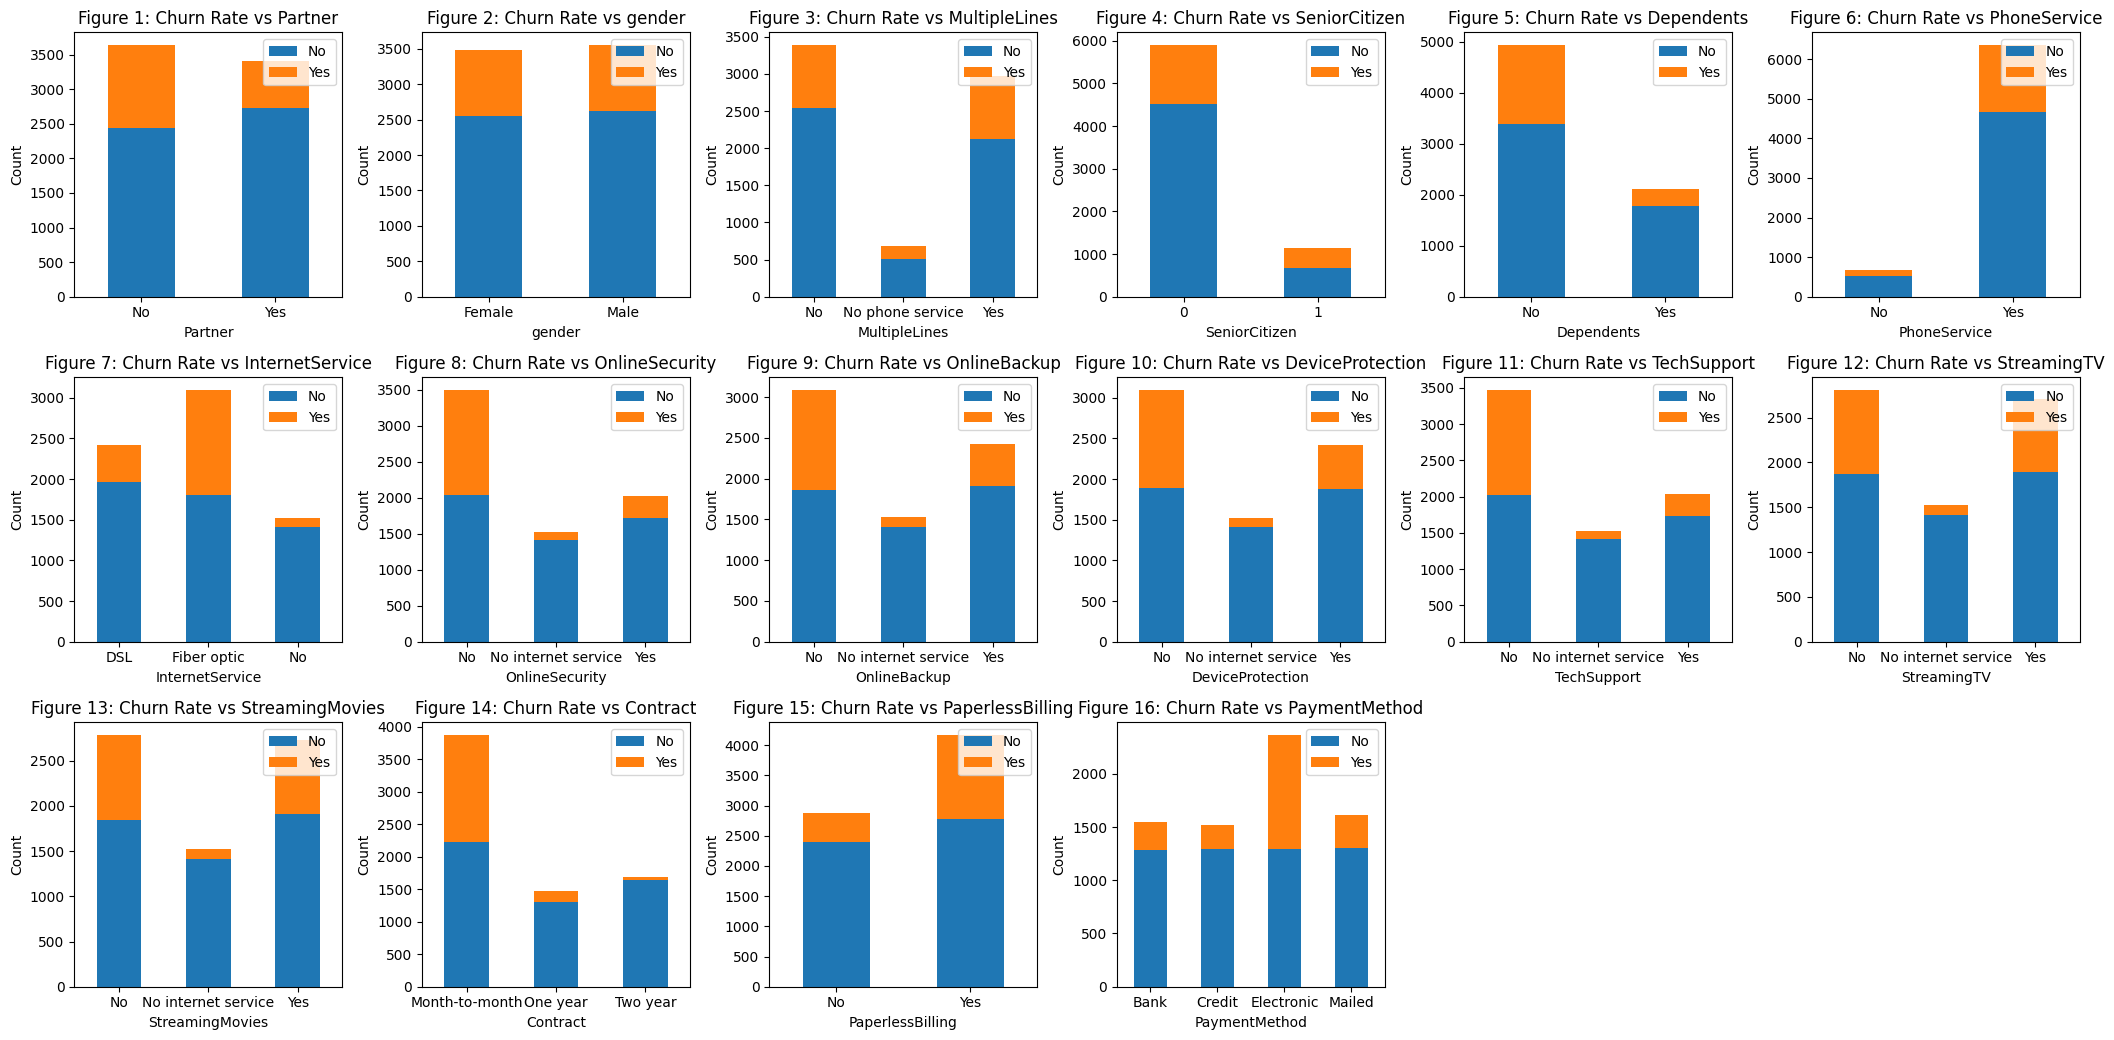

In [69]:
import matplotlib.pyplot as plt
n_rows = 3
n_cols = 6
fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3.5, n_rows * 3.5))

for r in range(n_rows):
    for c in range(n_cols):
        i = r * n_cols + c
        if i < len(cols):
            ax_i = ax[r, c]
            churn_by = df.groupBy(cols[i], "Churn").count().toPandas()
            pivot_data = churn_by.pivot(index=cols[i], columns="Churn", values="count")
            pivot_data.plot(kind="bar", stacked=True, ax=ax_i)
            ax_i.set_title(f"Figure {i+1}: Churn Rate vs {cols[i]}")
            ax_i.legend(title="", loc="upper right", labels=["No", "Yes"])
            ax_i.set_xlabel(cols[i])
            ax_i.set_ylabel("Count")
            ax_i.tick_params(axis='x', rotation=0)
        else:
            ax[r, c].axis("off")

plt.tight_layout()
plt.show()

### **2.5. Plot Histogram for Numerical columns**

#### 2.5.1. MonthlyCharges

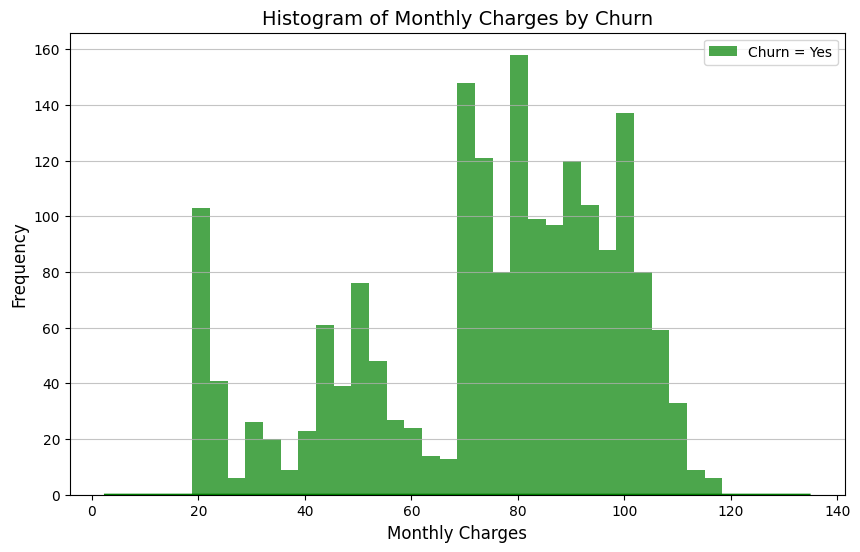

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
data = df.select("MonthlyCharges", "Churn").toPandas()
churn_yes = data[data["Churn"] == "Yes"]["MonthlyCharges"]
plt.figure(figsize=(10, 6))
plt.hist(churn_yes, bins=30, alpha=0.7, label="Churn = Yes", color="green")
sns.kdeplot(churn_yes, color="green")
plt.title("Histogram of Monthly Charges by Churn", fontsize=14)
plt.xlabel("Monthly Charges", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend(loc="upper right")
plt.grid(axis="y", alpha=0.75)
plt.show()

#### 2.5.2. Tenure

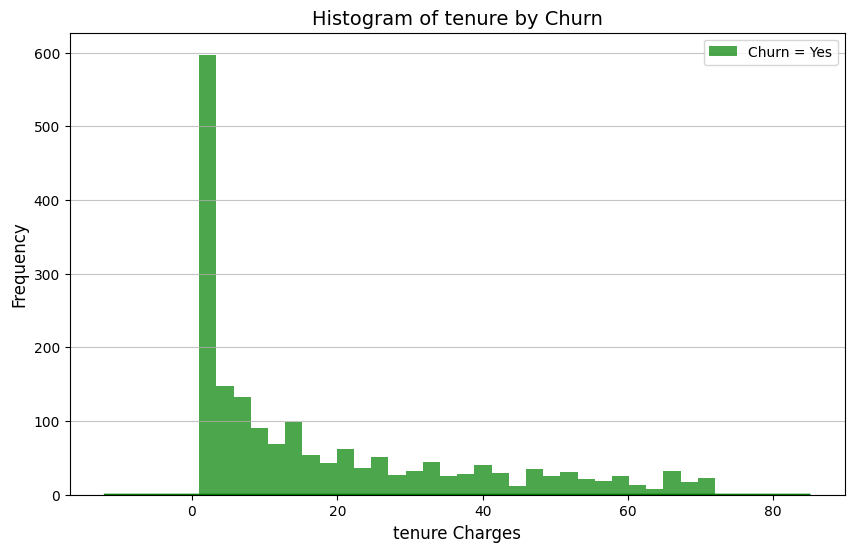

In [71]:
data = df.select("tenure", "Churn").toPandas()
churn_yes = data[data["Churn"] == "Yes"]["tenure"]
plt.figure(figsize=(10, 6))
plt.hist(churn_yes, bins=30, alpha=0.7, label="Churn = Yes", color="green")
sns.kdeplot(churn_yes, color="green")
plt.title("Histogram of tenure by Churn", fontsize=14)
plt.xlabel("tenure Charges", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend(loc="upper right")
plt.grid(axis="y", alpha=0.75)
plt.show()

## **3. Feature Engineering**

### **3.1. Create additional features from the existing data that might be predictive of churn, such as customer tenure, usage patterns, or engagement metrics**

#### 3.1.1. Tenure Grouping (Grouping according to service usage time): Tenure can have a big impact on churn. You can divide tenure into groups to better understand the relationship with churn.

In [72]:
from pyspark.sql.functions import when
df = df.withColumn(
    "TenureGroup",
    when(df["tenure"] < 12, "0-12 months")
    .when(df["tenure"].between(12, 24), "12-24 months")
    .when(df["tenure"].between(24, 36), "24-36 months")
    .when(df["tenure"].between(36, 48), "36-48 months")
    .otherwise("48+ months")
)

df.select('TenureGroup').show()

+------------+
| TenureGroup|
+------------+
| 0-12 months|
|24-36 months|
| 0-12 months|
|36-48 months|
| 0-12 months|
| 0-12 months|
|12-24 months|
| 0-12 months|
|24-36 months|
|  48+ months|
|12-24 months|
|12-24 months|
|  48+ months|
|  48+ months|
|24-36 months|
|  48+ months|
|  48+ months|
|  48+ months|
| 0-12 months|
|12-24 months|
+------------+
only showing top 20 rows



### 3.1.2. Total Charges per Month (Monthly payment amount): Calculating average monthly charges (with MonthlyCharges and tenure) can show changes in customer spending behavior.

In [73]:
df = df.withColumn("AverageCharges", df["TotalCharges"] / df["tenure"])
df.select('AverageCharges').show()

+------------------+
|    AverageCharges|
+------------------+
|             29.85|
|  55.5735294117647|
|            54.075|
| 40.90555555555556|
|            75.825|
|          102.5625|
| 88.60909090909091|
|30.189999999999998|
|108.78750000000001|
| 56.25725806451613|
| 45.18846153846154|
|            20.425|
|             97.95|
|102.78163265306122|
|107.44200000000001|
|114.42246376811593|
|19.672115384615385|
|103.97535211267606|
|            52.835|
| 88.70952380952382|
+------------------+
only showing top 20 rows



###  3.1.3. Engagement Metric: Services like PhoneService, InternetService, TechSupport, StreamingTV, StreamingMovies can reflect customer engagement. You can create an aggregated index of service usage.

In [74]:
df = df.withColumn(
    "Engagement",
    when(df["PhoneService"] == "Yes", 1).otherwise(0) +
    when(df["InternetService"] == "Fiber optic", 1).otherwise(0) +
    when(df["TechSupport"] == "Yes", 1).otherwise(0) +
    when(df["StreamingTV"] == "Yes", 1).otherwise(0) +
    when(df["StreamingMovies"] == "Yes", 1).otherwise(0)
)

df.select('Engagement').show()

+----------+
|Engagement|
+----------+
|         0|
|         1|
|         1|
|         1|
|         2|
|         4|
|         3|
|         0|
|         5|
|         1|
|         1|
|         1|
|         4|
|         4|
|         5|
|         5|
|         1|
|         4|
|         2|
|         3|
+----------+
only showing top 20 rows



### **3.2. Perform feature selection to identify the most relevant features for modeling**
- We can drop some features: customerID, TotalCharges, MonthlyCharges, tenure
- Select Feature columns: numerical columns
- Select Categorical columns: string columns


In [75]:
feature_cols=["AverageCharges","Engagement",]
categorical_cols = ["Partner","MultipleLines",'gender', "SeniorCitizen", "Dependents", "PhoneService",
                    "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport",
                    "StreamingTV", "StreamingMovies", "Contract", "PaperlessBilling", "PaymentMethod","TenureGroup"]

## **4.	Model Development**

### **4.1. Preprocessing and split the dataset into training and testing sets**

In [76]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, Imputer
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline

In [77]:
stringindexer_stages = [StringIndexer(inputCol=c, outputCol='strindexed_' + c) for c in categorical_cols]
onehotencoder_stages = [OneHotEncoder(inputCol='strindexed_' + c, outputCol='onehot_' + c) for c in categorical_cols]
feature_columns = ['onehot_' + c for c in categorical_cols]+feature_cols
vectorassembler_stage = VectorAssembler(inputCols=feature_columns, outputCol='features')
imputer = Imputer(
    inputCols=feature_cols,
    outputCols=feature_cols,
    strategy="mean"
)
indexer = StringIndexer(inputCol="Churn", outputCol="label")

In [78]:
all_stages = stringindexer_stages + onehotencoder_stages + [indexer, imputer, vectorassembler_stage]
pipeline = Pipeline(stages=all_stages)

In [79]:
pipeline_model = pipeline.fit(df)
final_columns = feature_columns + ["features","label"]
df = pipeline_model.transform(df).\
            select(final_columns)
df.show(5)

+--------------+--------------------+-------------+--------------------+-----------------+-------------------+----------------------+---------------------+-------------------+-----------------------+------------------+------------------+----------------------+---------------+-----------------------+--------------------+------------------+-----------------+----------+--------------------+-----+
|onehot_Partner|onehot_MultipleLines|onehot_gender|onehot_SeniorCitizen|onehot_Dependents|onehot_PhoneService|onehot_InternetService|onehot_OnlineSecurity|onehot_OnlineBackup|onehot_DeviceProtection|onehot_TechSupport|onehot_StreamingTV|onehot_StreamingMovies|onehot_Contract|onehot_PaperlessBilling|onehot_PaymentMethod|onehot_TenureGroup|   AverageCharges|Engagement|            features|label|
+--------------+--------------------+-------------+--------------------+-----------------+-------------------+----------------------+---------------------+-------------------+-----------------------+-------

In [80]:
training, test = df.randomSplit([0.8, 0.2], seed=42)

### **4.2. Decision Tree Classification**

In [81]:
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
dt = DecisionTreeClassifier(featuresCol='features', labelCol='label')
param_grid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [3, 5, 7]) \
    .addGrid(dt.maxBins, [32, 64]) \
    .addGrid(dt.minInstancesPerNode, [1, 2]) \
    .build()

evaluator = MulticlassClassificationEvaluator(metricName="accuracy")

cross_validator = CrossValidator(
    estimator=dt,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    numFolds=5
)

cv_model = cross_validator.fit(training)
best_model = cv_model.bestModel
predictions_dt = best_model.transform(test)
predictions_dt.select("label", "prediction", "probability").show(10)

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  0.0|       0.0|[0.93162393162393...|
|  1.0|       0.0|[0.71640735502121...|
|  1.0|       0.0|[0.71640735502121...|
|  0.0|       0.0|[0.93162393162393...|
|  1.0|       0.0|[0.71640735502121...|
|  0.0|       0.0|[0.71640735502121...|
|  0.0|       0.0|[0.93162393162393...|
|  0.0|       0.0|[0.71640735502121...|
|  0.0|       0.0|[0.93162393162393...|
|  0.0|       0.0|[0.93162393162393...|
+-----+----------+--------------------+
only showing top 10 rows



In [82]:
accuracy_evaluator_dt= MulticlassClassificationEvaluator(
    labelCol="label", metricName='accuracy'
)
accuracy_dt= accuracy_evaluator_dt.evaluate(predictions_dt)
print(f"Accuracy: {accuracy_dt:.4f}")
precision_evaluator_dt = MulticlassClassificationEvaluator(
    labelCol="label", metricName='weightedPrecision'
)
precision_dt= precision_evaluator_dt.evaluate(predictions_dt)
print(f"Precision: {precision_dt:.4f}")
recall_evaluator = MulticlassClassificationEvaluator(
    labelCol="label", metricName="weightedRecall"
)
recall_dt =recall_evaluator.evaluate(predictions_dt)
print(f"Recall: {recall_dt:.4f}")

Accuracy: 0.7866
Precision: 0.7857
Recall: 0.7866


### **4.3. Logistic Regression**

In [83]:
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier
LogR=LogisticRegression(featuresCol='features', labelCol='label')

param_grid2 = ParamGridBuilder() \
    .addGrid(LogR.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(LogR.elasticNetParam, [0.0, 0.5, 1.0]) \
    .addGrid(LogR.maxIter, [10, 50, 100]) \
    .build()

evaluator2 = BinaryClassificationEvaluator(
    labelCol="label",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

cross_validator2 = CrossValidator(
    estimator=LogR,
    estimatorParamMaps=param_grid2,
    evaluator=evaluator2,
    numFolds=5
)

cv_model2 = cross_validator2.fit(training)
best_model2 = cv_model2.bestModel
predictions_logr = best_model2.transform(test)
predictions_logr.select("label", "prediction", "probability").show(10)

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  0.0|       0.0|[0.89227290581123...|
|  1.0|       1.0|[0.33851823099686...|
|  1.0|       0.0|[0.60821374934108...|
|  0.0|       0.0|[0.89930697743891...|
|  1.0|       0.0|[0.52802518583940...|
|  0.0|       0.0|[0.68370596085473...|
|  0.0|       0.0|[0.85288813996705...|
|  0.0|       0.0|[0.70069859037381...|
|  0.0|       0.0|[0.97988145671825...|
|  0.0|       0.0|[0.91336840201365...|
+-----+----------+--------------------+
only showing top 10 rows



In [85]:
accuracy_evaluator_logr= MulticlassClassificationEvaluator(
    labelCol="label", metricName='accuracy'
)
accuracy_logr= accuracy_evaluator_logr.evaluate(predictions_logr)
print(f"Accuracy: {accuracy_logr:.4f}")
precision_evaluator_logr = MulticlassClassificationEvaluator(
    labelCol="label", metricName='weightedPrecision'
)
precision_logr= precision_evaluator_logr.evaluate(predictions_logr)
print(f"Precision: {precision_logr:.4f}")
recall_evaluator_logr= MulticlassClassificationEvaluator(
    labelCol="label", metricName="weightedRecall"
)
recall_logr =recall_evaluator_logr.evaluate(predictions_logr)
print(f"Recall: {recall_logr:.4f}")

Accuracy: 0.8097
Precision: 0.8025
Recall: 0.8097


### **4.4. Conclusion:**  
- The accuracy of Logistic Regression is higher than Decision Tree. Because the customer churn dataset also contain the important numerical features like TotalCharges and tenure, which Decision doesn't do well with